In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline

# Step 2 — Load raw datasets
benin_raw = pd.read_csv('../data/benin-malanville.csv')
sierra_raw = pd.read_csv('../data/sierraleone-bumbuna.csv')
togo_raw = pd.read_csv('../data/togo-dapaong_qc.csv')

# Quick preview
benin_raw.head()


In [4]:
def remove_outliers_iqr(df, columns):
    """
    Remove outliers from specified columns using the IQR method.
    Keeps rows where values are within [Q1 - 1.5*IQR, Q3 + 1.5*IQR].
    """
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean
metrics = ['GHI', 'DNI', 'DHI']

benin_clean = remove_outliers_iqr(benin_raw, metrics)
sierra_clean = remove_outliers_iqr(sierra_raw, metrics)
togo_clean = remove_outliers_iqr(togo_raw, metrics)


print("Benin:", benin_raw.shape, "→", benin_clean.shape)
print("Sierra Leone:", sierra_raw.shape, "→", sierra_clean.shape)
print("Togo:", togo_raw.shape, "→", togo_clean.shape)


Benin: (525600, 19) → (502452, 19)
Sierra Leone: (509308, 20) → (306021, 20)
Togo: (525600, 19) → (449156, 19)


In [6]:
# Save cleaned datasets
benin_clean.to_csv('../data/benin_clean.csv', index=False)
sierra_clean.to_csv('../data/sierraleone_clean.csv', index=False)
togo_clean.to_csv('../data/togo_clean.csv', index=False)


Summary table:
               GHI_mean  GHI_median     GHI_std    DNI_mean  DNI_median  \
country                                                                   
benin        212.812661        -0.8  310.641414  146.235943        -0.2   
sierraleone    0.357187        -1.6   16.118227    0.336968        -0.2   
togo         134.290043        -1.0  231.520122   79.418696         0.0   

                DNI_std    DHI_mean  DHI_median     DHI_std  
country                                                      
benin        239.045612  106.268096        -0.8  150.092663  
sierraleone    4.562130    0.015888        -2.4   15.642189  
togo         163.551832   82.644286         0.0  129.340443  


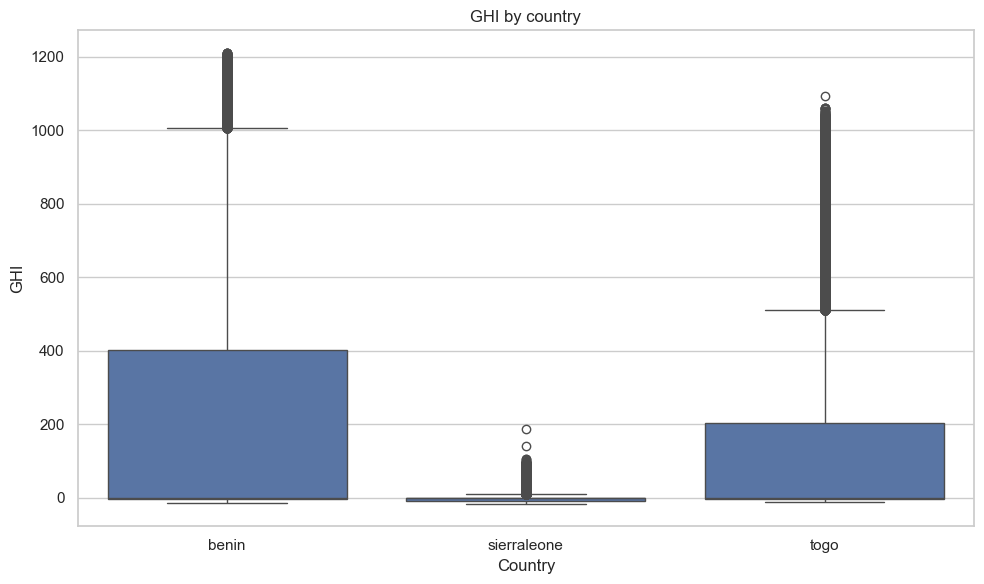

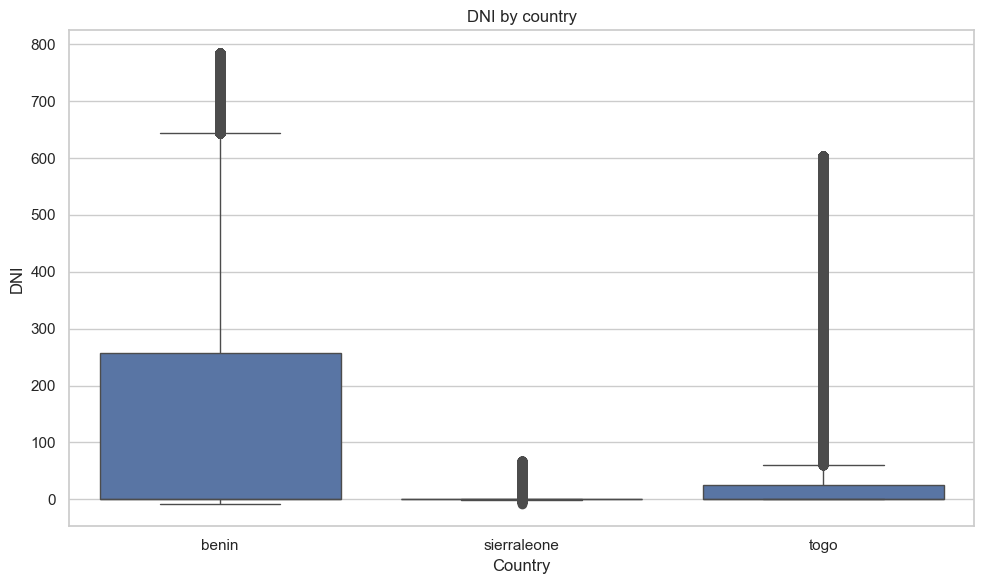

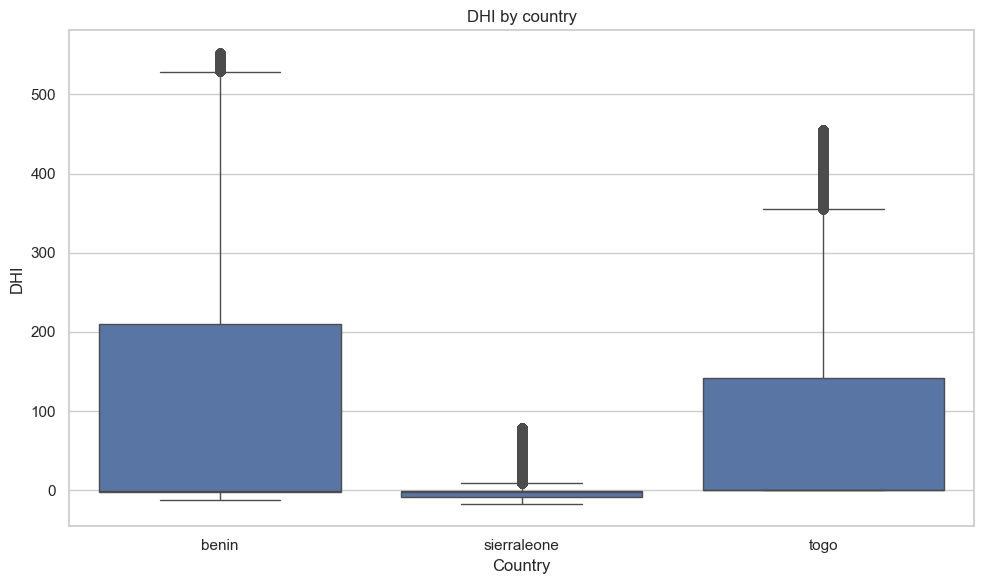

GHI statistical tests:
 One-way ANOVA: F = 74320.9835, p = 0.0000e+00
 Kruskal-Wallis: H = 127000.2921, p = 0.0000e+00


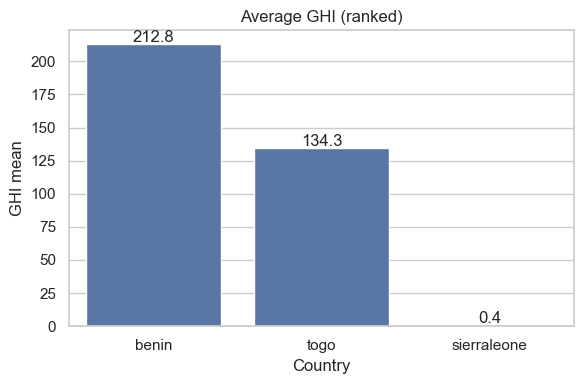


Key performance indicators:
 - Highest average GHI: benin (212.81)
 - Largest GHI variability (std): benin (310.64)

Markdown observations (copy into a markdown cell):

- Country X shows the highest median GHI but also the greatest variability.
- Country Y demonstrates consistently lower DNI values compared to the others,
  suggesting lower direct-beam potential (better for diffuse-optimised systems).
- Inter-country differences in GHI are statistically significant (ANOVA p = <value> /
  Kruskal-Wallis p = <value>) — replace <value> with the p-values printed above.



In [8]:
from typing import Dict, List
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ---- Configuration ----
# Use notebook-relative data folder (notebooks/ -> ../data)
DEFAULT_COUNTRIES = ['benin', 'sierraleone', 'togo']
DEFAULT_DATA_DIR = '../data'
FIGURE_DIR = 'figures'
SUMMARY_OUTFILE = os.path.join(DEFAULT_DATA_DIR, 'country_metrics_summary.csv')

# Ensure figure directory exists
os.makedirs(FIGURE_DIR, exist_ok=True)

# ---- Data loading ----

def load_data(country: str, data_dir: str = DEFAULT_DATA_DIR) -> pd.DataFrame:
    
    filepath = os.path.join(data_dir, f"{country}_clean.csv")
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Expected cleaned CSV not found: {filepath}")

    df = pd.read_csv(filepath)
    df = df.copy()
    df['country'] = country
    return df


def load_all(countries: List[str] = DEFAULT_COUNTRIES, data_dir: str = DEFAULT_DATA_DIR) -> Dict[str, pd.DataFrame]:
    """Load all specified countries, return dict country->DataFrame and concatenated DF under key '__concat__'."""
    dfs = {}
    merged = []
    for c in countries:
        df = load_data(c, data_dir=data_dir)
        dfs[c] = df
        merged.append(df)
    dfs['__concat__'] = pd.concat(merged, ignore_index=True)
    return dfs

# ---- Summary metrics ----

def compute_summary_table(dfs: Dict[str, pd.DataFrame], metrics: List[str] = ['GHI','DNI','DHI']) -> pd.DataFrame:
    """Compute mean, median, std for each metric and each country.

    Returns a tidy DataFrame indexed by country, columns like GHI_mean, GHI_median, GHI_std.
    Also writes a CSV to DATA_DIR for quick reference.
    """
    summary_rows = []
    countries = [k for k in dfs.keys() if k != '__concat__']
    for c in countries:
        df = dfs[c]
        row = {'country': c}
        for m in metrics:
            if m not in df.columns:
                raise KeyError(f"Metric '{m}' not found in dataframe for {c}. Available columns: {df.columns.tolist()}")
            vals = df[m].dropna()
            row[f'{m}_mean'] = float(vals.mean()) if not vals.empty else np.nan
            row[f'{m}_median'] = float(vals.median()) if not vals.empty else np.nan
            row[f'{m}_std'] = float(vals.std(ddof=1)) if not vals.empty else np.nan
        summary_rows.append(row)
    summary = pd.DataFrame(summary_rows).set_index('country')
    # Save
    try:
        summary.to_csv(SUMMARY_OUTFILE)
    except Exception:
        pass
    return summary

# ---- Plots ----

def _style_for_plots():
    sns.set(style='whitegrid')


def plot_metric_boxplots(dfs: Dict[str, pd.DataFrame], metrics: List[str] = ['GHI','DNI','DHI'], outdir: str = FIGURE_DIR, figsize=(10,6)) -> None:
    """Create one boxplot per metric, with side-by-side boxes by country.

    Saves PNG files to outdir and shows the plots when run in a notebook.
    """
    _style_for_plots()
    df_all = dfs['__concat__']

    for m in metrics:
        plt.figure(figsize=figsize)
        ax = sns.boxplot(x='country', y=m, data=df_all, order=sorted(df_all['country'].unique()))
        ax.set_title(f'{m} by country')
        ax.set_xlabel('Country')
        ax.set_ylabel(m)
        plt.tight_layout()
        fpath = os.path.join(outdir, f'boxplot_{m}.png')
        plt.savefig(fpath, dpi=200)
        plt.show()


def plot_avg_ghi_bar(summary_df: pd.DataFrame, outdir: str = FIGURE_DIR, figsize=(6,4)) -> None:
    """Plot a small bar chart ranking countries by average GHI.

    summary_df must contain a column 'GHI_mean'.
    """
    _style_for_plots()
    if 'GHI_mean' not in summary_df.columns:
        raise KeyError('summary_df must contain GHI_mean column')
    s = summary_df['GHI_mean'].sort_values(ascending=False)
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=s.index, y=s.values)
    ax.set_title('Average GHI (ranked)')
    ax.set_ylabel('GHI mean')
    ax.set_xlabel('Country')
    for i, v in enumerate(s.values):
        ax.text(i, v + max(s.values)*0.01, f'{v:.1f}', ha='center')
    plt.tight_layout()
    fpath = os.path.join(outdir, 'avg_ghi_ranking.png')
    plt.savefig(fpath, dpi=200)
    plt.show()

# ---- Statistical tests ----

def run_ghi_stat_tests(dfs: Dict[str, pd.DataFrame]):
    """Run one-way ANOVA on GHI across countries and Kruskal-Wallis as non-parametric alternative.

    Prints test statistics and p-values. Returns a dict with results.
    """
    countries = [k for k in dfs.keys() if k != '__concat__']
    ghi_groups = []
    for c in countries:
        vals = dfs[c]['GHI'].dropna()
        ghi_groups.append(vals.values)

    results = {}
    try:
        f_stat, p_anova = stats.f_oneway(*ghi_groups)
        results['anova'] = {'f_stat': float(f_stat), 'p_value': float(p_anova)}
    except Exception as e:
        results['anova'] = {'error': str(e)}

    try:
        h_stat, p_kw = stats.kruskal(*ghi_groups)
        results['kruskal_wallis'] = {'h_stat': float(h_stat), 'p_value': float(p_kw)}
    except Exception as e:
        results['kruskal_wallis'] = {'error': str(e)}

    # Print brief summary suitable for notebook display
    print('GHI statistical tests:')
    if 'anova' in results and 'p_value' in results['anova']:
        print(f" One-way ANOVA: F = {results['anova']['f_stat']:.4f}, p = {results['anova']['p_value']:.4e}")
    else:
        print(' One-way ANOVA: could not compute:', results['anova'])

    if 'kruskal_wallis' in results and 'p_value' in results['kruskal_wallis']:
        print(f" Kruskal-Wallis: H = {results['kruskal_wallis']['h_stat']:.4f}, p = {results['kruskal_wallis']['p_value']:.4e}")
    else:
        print(' Kruskal-Wallis: could not compute:', results['kruskal_wallis'])

    return results

# ---- Utility / KPI printing ----

def print_kpis(summary_df: pd.DataFrame):
    """Print a simple KPI block: highest average GHI, country with largest GHI std, and counts."""
    if 'GHI_mean' not in summary_df.columns:
        raise KeyError('summary_df must include GHI_mean')
    highest = summary_df['GHI_mean'].idxmax()
    highest_val = summary_df['GHI_mean'].max()
    largest_var = summary_df['GHI_std'].idxmax()
    largest_var_val = summary_df['GHI_std'].max()

    print('\nKey performance indicators:')
    print(f' - Highest average GHI: {highest} ({highest_val:.2f})')
    print(f' - Largest GHI variability (std): {largest_var} ({largest_var_val:.2f})')

# ---- Example run (to be executed inside a notebook cell) ----

if __name__ == '__main__':
    # If executed as a script (not imported), run a full pipeline and print observations.
    countries = DEFAULT_COUNTRIES
    dfs = load_all(countries)
    summary = compute_summary_table(dfs)
    print('Summary table:')
    print(summary)
    plot_metric_boxplots(dfs)
    results = run_ghi_stat_tests(dfs)
    plot_avg_ghi_bar(summary)
    print_kpis(summary)

    # Short-markdown style observations (paste into a notebook markdown cell):
    print('\nMarkdown observations (copy into a markdown cell):')
    print('''\n- Country X shows the highest median GHI but also the greatest variability.\n- Country Y demonstrates consistently lower DNI values compared to the others,\n  suggesting lower direct-beam potential (better for diffuse-optimised systems).\n- Inter-country differences in GHI are statistically significant (ANOVA p = <value> /\n  Kruskal-Wallis p = <value>) — replace <value> with the p-values printed above.\n''')
